In [19]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim.downloader as api
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seoyoungyoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/seoyoungyoon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
relevancy_scores = pd.read_csv("original_dataset/relevancy_scores.csv")
relevant_docs = pd.read_csv("original_dataset/relevant_document_list.csv")

In [22]:
relevancy_scores.head()

,internal_id,keywords,abstract,title,manual_screen_score,relevancy,predicted_screen_score
0,40941026,Hydrogen Fuel Cells|Alkaline Fuel Cells|Fuel C...,This paper presents the experimental results o...,An actively controlled fuel cell/battery hybri...,1.0,NaN,NaN
1,40941027,Detonation-to-Deflagration Transition,Lithium-ion batteries (LIBs) have been widely ...,Characterization of the deflagration behavior ...,-1.0,NaN,NaN
2,40941028,PEM Fuel Cells|Battery Management Systems|Hydr...,NaN,Intelligent Control Strategy for Energy Manage...,-1.0,NaN,NaN
3,40941029,Power Management Strategy|Battery Life Optimiz...,The Energy Management Strategy (EMS) in Fuel C...,Multi-Objective Optimization-Based Health-Cons...,1.0,NaN,NaN
4,40941030,Battery Life Optimization|Battery Technology,"Currently, major vehicle manufacturers are wor...",The choice of a performance criterion for a hi...,1.0,NaN,NaN


In [23]:
relevant_docs.head()

,(internal) id,(source) id,keywords,abstract,title,journal,authors,doi
0,40941026,https://openalex.org,Hydrogen Fuel Cells|Alkaline Fuel Cells|Fuel C...,This paper presents the experimental results o...,An actively controlled fuel cell/battery hybri...,Journal of power sources,Lijun Gao|Zhenhua Jiang|Roger A. Dougal,https://doi.org/10.1016/j.jpowsour.2003.12.052
1,40941029,https://openalex.org,Power Management Strategy|Battery Life Optimiz...,The Energy Management Strategy (EMS) in Fuel C...,Multi-Objective Optimization-Based Health-Cons...,Energies,Mehdi Sellali|Alexandre Ravey|Achour Betka|Abd...,https://doi.org/10.3390/en15041318
2,40941030,https://openalex.org,Battery Life Optimization|Battery Technology,"Currently, major vehicle manufacturers are wor...",The choice of a performance criterion for a hi...,IOP conference series. Materials science and e...,I. A. Lyubimov|Р. Х. Курмаев,https://doi.org/10.1088/1757-899x/819/1/012015
3,40941032,https://openalex.org,Battery Technology,Battery electric vehicles (BEVs) and fuel cell...,A comparative assessment of battery and fuel c...,Energy,Mengyu Li|Xiongwen Zhang|Guojun Li,https://doi.org/10.1016/j.energy.2015.11.023
4,40941035,https://openalex.org,PEM Fuel Cells|Hydrogen Fuel Cells|Fuel Cell D...,This paper develops a proton exchange membrane...,Cost analyses and optimization of a PEMFC elec...,NaN,Yu-Ting Teng|Fu-Cheng Wang,https://doi.org/10.1109/sii.2016.7844112


## Data Cleaning

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"\?\?\?", "", text)
    text = re.sub(r"\[\]|\(\)", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\bev\b", "electric vehicle", text)
    text = re.sub(r"\bli[\-\s]?ion\b", "lithium ion", text)
    text = re.sub(r"\bh2\b", "hydrogen", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [25]:
relevancy_scores['clean_abstract'] = relevancy_scores['abstract'].apply(clean_text)
relevancy_scores['clean_title'] = relevancy_scores['title'].apply(clean_text)

# Remove missing rows
relevancy_scores.dropna(subset=['abstract', 'title'], inplace=True)

In [26]:
relevancy_scores.reset_index(drop=True, inplace=True)

In [27]:
relevancy_scores

,internal_id,keywords,abstract,title,manual_screen_score,relevancy,predicted_screen_score,clean_abstract,clean_title
0,40941026,Hydrogen Fuel Cells|Alkaline Fuel Cells|Fuel C...,This paper presents the experimental results o...,An actively controlled fuel cell/battery hybri...,1.0,NaN,NaN,this paper presents the experimental results o...,an actively controlled fuel cellbattery hybrid...
1,40941027,Detonation-to-Deflagration Transition,Lithium-ion batteries (LIBs) have been widely ...,Characterization of the deflagration behavior ...,-1.0,NaN,NaN,lithiumion batteries libs have been widely use...,characterization of the deflagration behavior ...
2,40941029,Power Management Strategy|Battery Life Optimiz...,The Energy Management Strategy (EMS) in Fuel C...,Multi-Objective Optimization-Based Health-Cons...,1.0,NaN,NaN,the energy management strategy ems in fuel cel...,multiobjective optimizationbased healthconscio...
3,40941030,Battery Life Optimization|Battery Technology,"Currently, major vehicle manufacturers are wor...",The choice of a performance criterion for a hi...,1.0,NaN,NaN,currently major vehicle manufacturers are work...,the choice of a performance criterion for a hi...
4,40941031,Battery Management Systems,There are an increasing number of vehicle choi...,Solar photovoltaic charging of high voltage ni...,-1.0,NaN,NaN,there are an increasing number of vehicle choi...,solar photovoltaic charging of high voltage ni...
...,...,...,...,...,...,...,...,...,...
223,40941319,Battery Management Systems,"Full-profile, Rietveld-type, x-ray powder diff...",Structural Parameters of ???? ??????? PbO2 and...,NaN,0.510935,-1.0,fullprofile rietveldtype xray powder diffracti...,structural parameters of pbo2 and their relati...
224,40941320,Power Management Strategy|Battery Life Optimiz...,The use of multi-stack fuel cells (FCs) is att...,Q-learning based energy management strategy fo...,NaN,0.587763,1.0,the use of multistack fuel cells fcs is attrac...,qlearning based energy management strategy for...
225,40941321,Power Management Strategy|Battery Life Optimiz...,This paper focus on offline energy management ...,Hybrid Systems Energy Management Using Optimiz...,NaN,0.562984,1.0,this paper focus on offline energy management ...,hybrid systems energy management using optimiz...
226,40941323,PEM Fuel Cells|Fuel Cell Durability|Hydrogen F...,Under the background of energy and environment...,Design of energy and materials for ammonia-bas...,NaN,0.721312,1.0,under the background of energy and environment...,design of energy and materials for ammoniabase...


In [28]:
relevancy_scores.to_csv('cleaned_dataset.csv')

## TF-IDF RELEVANCE SCORING

In [29]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
doc_vectors = tfidf_vectorizer.fit_transform(relevancy_scores['clean_abstract'])

query = "electric vehicle battery hydrogen lithium ion"
query_vector = tfidf_vectorizer.transform([query])

cos_sim = cosine_similarity(query_vector, doc_vectors).flatten()
relevancy_scores['tfidf_score'] = cos_sim

## Word-to-vec scoring

In [30]:
word2vec = api.load("glove-wiki-gigaword-100")

def get_doc_embedding(doc):
    words = [lemmatizer.lemmatize(w) for w in doc.split() if w not in stop_words and w in word2vec]
    if not words:
        return np.zeros(100)
    return np.mean([word2vec[w] for w in words], axis=0)

tqdm.pandas()
relevancy_scores['embedding'] = relevancy_scores['clean_abstract'].progress_apply(get_doc_embedding)
query_embedding = get_doc_embedding(query)
relevancy_scores['word2vec_score'] = relevancy_scores['embedding'].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

100%|███████████████████████████████████████| 228/228 [00:00<00:00, 2073.77it/s]


## Transformer scoring

In [31]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
doc_embeddings = model.encode(relevancy_scores['clean_abstract'].tolist())
query_embedding = model.encode([query])[0]
bert_scores = cosine_similarity([query_embedding], doc_embeddings)[0]
relevancy_scores['bert_score'] = bert_scores

/usr/local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Relevance score distribution

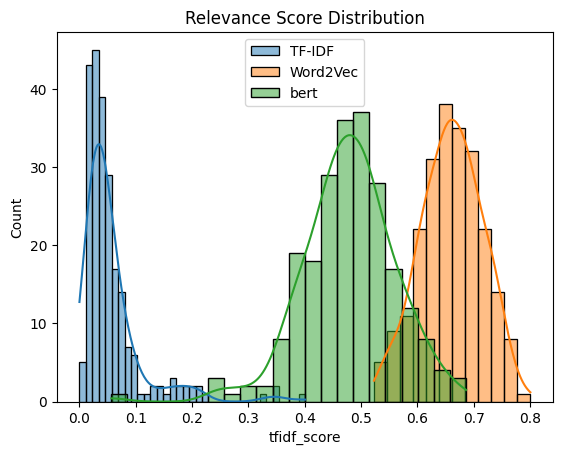

In [32]:
sns.histplot(relevancy_scores['tfidf_score'], kde=True, label='TF-IDF')
sns.histplot(relevancy_scores['word2vec_score'], kde=True, label='Word2Vec')
sns.histplot(relevancy_scores['bert_score'], kde=True, label='bert')
plt.title("Relevance Score Distribution")
plt.legend()
plt.show()

In [33]:
relevancy_scores

,internal_id,keywords,abstract,title,manual_screen_score,relevancy,predicted_screen_score,clean_abstract,clean_title,tfidf_score,embedding,word2vec_score,bert_score
0,40941026,Hydrogen Fuel Cells|Alkaline Fuel Cells|Fuel C...,This paper presents the experimental results o...,An actively controlled fuel cell/battery hybri...,1.0,NaN,NaN,this paper presents the experimental results o...,an actively controlled fuel cellbattery hybrid...,0.021253,"[-0.18766214, 0.22969504, 0.25723824, 0.099944...",0.661936,0.433878
1,40941027,Detonation-to-Deflagration Transition,Lithium-ion batteries (LIBs) have been widely ...,Characterization of the deflagration behavior ...,-1.0,NaN,NaN,lithiumion batteries libs have been widely use...,characterization of the deflagration behavior ...,0.011022,"[-0.25374344, 0.16612892, 0.21003911, 0.143541...",0.639267,0.403598
2,40941029,Power Management Strategy|Battery Life Optimiz...,The Energy Management Strategy (EMS) in Fuel C...,Multi-Objective Optimization-Based Health-Cons...,1.0,NaN,NaN,the energy management strategy ems in fuel cel...,multiobjective optimizationbased healthconscio...,0.027424,"[-0.28167388, 0.056939084, 0.18268956, 0.20269...",0.556875,0.487814
3,40941030,Battery Life Optimization|Battery Technology,"Currently, major vehicle manufacturers are wor...",The choice of a performance criterion for a hi...,1.0,NaN,NaN,currently major vehicle manufacturers are work...,the choice of a performance criterion for a hi...,0.073015,"[-0.3001513, 0.17137885, 0.23107193, 0.0769641...",0.698224,0.646875
4,40941031,Battery Management Systems,There are an increasing number of vehicle choi...,Solar photovoltaic charging of high voltage ni...,-1.0,NaN,NaN,there are an increasing number of vehicle choi...,solar photovoltaic charging of high voltage ni...,0.054091,"[-0.32109442, 0.16483626, 0.20467494, 0.080240...",0.734878,0.556804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,40941319,Battery Management Systems,"Full-profile, Rietveld-type, x-ray powder diff...",Structural Parameters of ???? ??????? PbO2 and...,NaN,0.510935,-1.0,fullprofile rietveldtype xray powder diffracti...,structural parameters of pbo2 and their relati...,0.042355,"[-0.18684515, 0.23661384, 0.064707085, 0.20652...",0.629596,0.442437
224,40941320,Power Management Strategy|Battery Life Optimiz...,The use of multi-stack fuel cells (FCs) is att...,Q-learning based energy management strategy fo...,NaN,0.587763,1.0,the use of multistack fuel cells fcs is attrac...,qlearning based energy management strategy for...,0.037246,"[-0.2704803, 0.08536447, 0.21564105, 0.0897237...",0.609778,0.399124
225,40941321,Power Management Strategy|Battery Life Optimiz...,This paper focus on offline energy management ...,Hybrid Systems Energy Management Using Optimiz...,NaN,0.562984,1.0,this paper focus on offline energy management ...,hybrid systems energy management using optimiz...,0.040125,"[-0.30820647, 0.17470753, 0.19377913, 0.192574...",0.621818,0.363700
226,40941323,PEM Fuel Cells|Fuel Cell Durability|Hydrogen F...,Under the background of energy and environment...,Design of energy and materials for ammonia-bas...,NaN,0.721312,1.0,under the background of energy and environment...,design of energy and materials for ammoniabase...,0.086371,"[-0.32574466, 0.2570984, 0.2671281, 0.03308826...",0.728007,0.529395


## Original score distribution

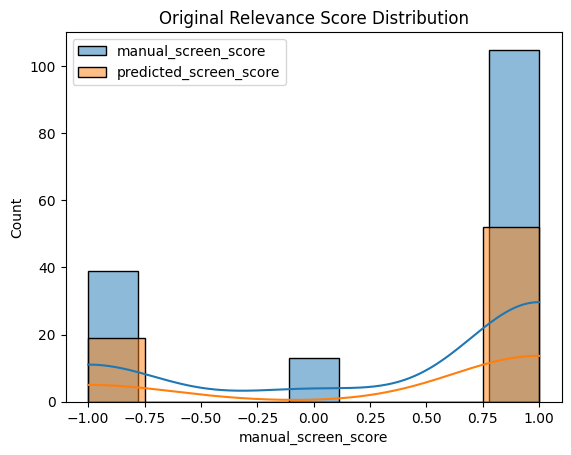

In [35]:
sns.histplot(relevancy_scores['manual_screen_score'], kde=True, label='manual_screen_score')
sns.histplot(relevancy_scores['predicted_screen_score'], kde=True, label='predicted_screen_score')
plt.title("Original Relevance Score Distribution")
plt.legend()
plt.show()

In [34]:
relevancy_scores.to_csv('completed_dataset.csv')